Notebook inspiré sur de nombreux points par l'article suivant https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

idéalement le notebook en tant que tel sans avoir à associer d'autres trucs. Il importe le dataset etc.

In [174]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [175]:
df1=pd.read_csv("https://www.cryptodatadownload.com/cdd/HitBTC_BTCUSD_d.csv", sep=",")
df1.tail()

,,,,,,,Timezones are UTC,https://www.CryptoDataDownload.com
1496102400.0,2017-05-30,BTCUSD,2190.99,2245,2112.15,2128.83,119.98,264635.83
1496016000.0,2017-05-29,BTCUSD,2081.89,2519.37,2007.34,2190.99,124.8,274085.52
1495929600.0,2017-05-28,BTCUSD,1917.45,2100,1834.79,2081.89,292.36,575658.65
1495843200.0,2017-05-27,BTCUSD,2285.29,2519.37,1865.07,1917.45,639.81,1344993.29
1495756800.0,2017-05-26,BTCUSD,2271.22,2455.4,2173,2285.29,224.1,516638.01


In [176]:
df=pd.read_csv("./Data/HitBTC_ETHUSD_1h.csv", sep=",")
df = df.rename(columns={'Close': 'value'})
new=df['value']
new=pd.DataFrame({'value':new.values})
new.shape
print(new[0:8])

    value
0  534.73
1  533.85
2  532.83
3  524.71
4  519.44
5  528.51
6  510.56
7  519.92


# Génération de features

Mise en forme séquentielle des données. Le but des cellules à venir est d'arriver à un jeu de la forme (batch,timesteps,features). Dans notre cas batch sera l'intégralité des individus du dataset, timesteps sera 100 (cf input dim), ie on va prédire à t+1 basé sur t, t-1,...,t-99 ; et on aura une feature : le prix de la crypto.

In [177]:
def generate_dataset(df, nb_timesteps):
    df_n=df.copy()
    for k in range(1,nb_timesteps): #à chaque ité on ajoute une colonne
        df_n[f"t-{k}"]=df_n["value"].shift(k)
    df_n=(df_n[nb_timesteps-1:][:])
    cols=(df_n.columns.to_list())[::-1]
    df_n=df_n[cols]
    return df_n

input_dim = 100

df_generated = generate_dataset(new, input_dim)
df_generated

,t-99,t-98,t-97,t-96,t-95,t-94,t-93,t-92,t-91,t-90,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,value
99,534.73,533.85,532.83,524.71,519.44,528.51,510.56,519.92,528.24,542.16,...,608.18,610.00,608.87,609.69,607.31,610.17,610.64,614.42,612.48,613.36
100,533.85,532.83,524.71,519.44,528.51,510.56,519.92,528.24,542.16,536.90,...,610.00,608.87,609.69,607.31,610.17,610.64,614.42,612.48,613.36,614.50
101,532.83,524.71,519.44,528.51,510.56,519.92,528.24,542.16,536.90,540.16,...,608.87,609.69,607.31,610.17,610.64,614.42,612.48,613.36,614.50,606.40
102,524.71,519.44,528.51,510.56,519.92,528.24,542.16,536.90,540.16,565.28,...,609.69,607.31,610.17,610.64,614.42,612.48,613.36,614.50,606.40,606.73
103,519.44,528.51,510.56,519.92,528.24,542.16,536.90,540.16,565.28,569.04,...,607.31,610.17,610.64,614.42,612.48,613.36,614.50,606.40,606.73,606.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5428,307.48,307.60,306.41,304.86,304.77,305.11,304.40,305.82,305.83,305.45,...,297.10,297.81,296.56,296.20,296.89,295.13,297.56,297.13,295.18,295.62
5429,307.60,306.41,304.86,304.77,305.11,304.40,305.82,305.83,305.45,306.11,...,297.81,296.56,296.20,296.89,295.13,297.56,297.13,295.18,295.62,293.98
5430,306.41,304.86,304.77,305.11,304.40,305.82,305.83,305.45,306.11,305.54,...,296.56,296.20,296.89,295.13,297.56,297.13,295.18,295.62,293.98,295.17
5431,304.86,304.77,305.11,304.40,305.82,305.83,305.45,306.11,305.54,307.40,...,296.20,296.89,295.13,297.56,297.13,295.18,295.62,293.98,295.17,294.34


In [178]:
"""scaler = MinMaxScaler(feature_range=(0,1))
df_scaled=scaler.fit_transform(df_generated)
df_scaled=pd.DataFrame(df_scaled,columns=df_generated.columns)
df_scaled.head()"""

'scaler = MinMaxScaler(feature_range=(0,1))\ndf_scaled=scaler.fit_transform(df_generated)\ndf_scaled=pd.DataFrame(df_scaled,columns=df_generated.columns)\ndf_scaled.head()'

# Feature engineering

Pour quand t'auras le temps bg

# Jeux d'entrainement et test

Très important ici : on deal avec des données séquentielles, il faut donc surtout pas shuffle au moment de la création des jeux de données. L'ordre doit rester le même.

In [215]:
output_timesteps=1 #nombre de prédictions faites à la suite. Time step of the output.
batch_size = 64
n_epochs = 10

In [216]:
def feature_label_split(df, target_cols):
    y = df[target_cols] #la variable à fitter est la première, on aura donc target col = value
    X = df.drop(columns=target_cols)
    scalerX = MinMaxScaler(feature_range=(0,1))
    scalerY = MinMaxScaler(feature_range=(0,1))
    X_scaled=scalerX.fit_transform(X)
    y_scaled=scalerY.fit_transform(y)
    return X_scaled, y_scaled, scalerX, scalerY

def train_val_test_split(df, target_cols, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y, scalerX, scalerY = feature_label_split(df, target_cols)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    print(y_test.shape)
    return X_train, X_val, X_test, y_train, y_val, y_test, scalerX, scalerY


cols=df_generated.columns.to_list()
cols=cols[len(cols)-output_timesteps:]
X_train, X_val, X_test, y_train, y_val, y_test, scalerX, scalerY = train_val_test_split(df_generated, cols, 0.2)

(1067, 1)


Ici on prend qu'une colonne à fitter. Gênant pour ensuite générer des séquences prédites plus longues?

# RNN

Pour entrainer un modèle tensorflow il est préférable d'avoir des données du type tensor.

In [217]:
X_train=tf.convert_to_tensor(X_train)
X_train=tf.reshape(X_train,shape=(X_train.shape[0],X_train.shape[1],1))

X_val=tf.convert_to_tensor(X_val)
X_val=tf.reshape(X_val,shape=(X_val.shape[0],X_val.shape[1],1))

X_test=tf.convert_to_tensor(X_test)
X_test=tf.reshape(X_test,shape=(X_test.shape[0],X_test.shape[1],1))

y_train=tf.convert_to_tensor(y_train)
y_train=tf.reshape(y_train,shape=(y_train.shape[0],y_train.shape[1],1))

y_val=tf.convert_to_tensor(y_val)
y_val=tf.reshape(y_val,shape=(y_val.shape[0],y_val.shape[1],1))

y_test=tf.convert_to_tensor(y_test)
y_test=tf.reshape(y_test,shape=(y_test.shape[0],y_test.shape[1],1))

In [218]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(3200, 99, 1) (1067, 99, 1) (1067, 99, 1) (3200, 1, 1) (1067, 1, 1) (1067, 1, 1)


units (# de neurones) n'a pas besoin d'être de la même longueur que la séquence.

In [219]:
model = keras.Sequential()
model.add(layers.SimpleRNN(32, input_shape=(X_train.shape[1],1), return_sequences=True))
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(output_timesteps))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_14 (SimpleRNN)   (None, 99, 32)            1088      
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [220]:
with tf.device('/cpu:0'):  #sinon ça fout la merde avec le cpu.

    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer='rmsprop',
        metrics=[tf.metrics.MeanAbsoluteError()]
    )


    history=model.fit(
        X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=n_epochs
    )

Epoch 1/10


2022-03-04 17:57:00.417171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.0722 - mean_absolute_error: 0.1388

2022-03-04 17:57:04.271852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 5s 92ms/step - loss: 0.0722 - mean_absolute_error: 0.1388 - val_loss: 0.0217 - val_mean_absolute_error: 0.1214
Epoch 2/10
50/50 [==============================] - 4s 87ms/step - loss: 0.0052 - mean_absolute_error: 0.0545 - val_loss: 0.0075 - val_mean_absolute_error: 0.0721
Epoch 3/10
50/50 [==============================] - 4s 86ms/step - loss: 0.0024 - mean_absolute_error: 0.0399 - val_loss: 0.0129 - val_mean_absolute_error: 0.1002
Epoch 4/10
50/50 [==============================] - 4s 87ms/step - loss: 0.0016 - mean_absolute_error: 0.0315 - val_loss: 0.0024 - val_mean_absolute_error: 0.0416
Epoch 5/10
50/50 [==============================] - 4s 87ms/step - loss: 0.0010 - mean_absolute_error: 0.0247 - val_loss: 0.0028 - val_mean_absolute_error: 0.0472
Epoch 6/10
50/50 [==============================] - 4s 86ms/step - loss: 9.3784e-04 - mean_absolute_error: 0.0245 - val_loss: 7.1686e-04 - val_mean_absolute_error: 0.0210
Epoch 7/10
50/50 [=======

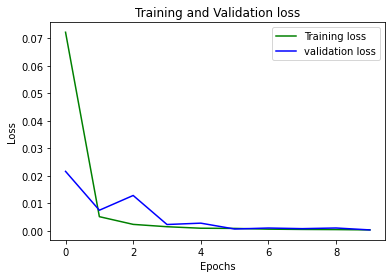

In [223]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,n_epochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [224]:
y_pred=model(X_test)

on va rescale les données.

In [225]:
y_pred=scalerY.inverse_transform(y_pred)

generate columns. C'est cochon à refaire qd t'as le time.

In [188]:
colsnames=[]
for i in range(0,100):
    colsnames.append('T-{}'.format(i))

colsnames

['T-0',
 'T-1',
 'T-2',
 'T-3',
 'T-4',
 'T-5',
 'T-6',
 'T-7',
 'T-8',
 'T-9',
 'T-10',
 'T-11',
 'T-12',
 'T-13',
 'T-14',
 'T-15',
 'T-16',
 'T-17',
 'T-18',
 'T-19',
 'T-20',
 'T-21',
 'T-22',
 'T-23',
 'T-24',
 'T-25',
 'T-26',
 'T-27',
 'T-28',
 'T-29',
 'T-30',
 'T-31',
 'T-32',
 'T-33',
 'T-34',
 'T-35',
 'T-36',
 'T-37',
 'T-38',
 'T-39',
 'T-40',
 'T-41',
 'T-42',
 'T-43',
 'T-44',
 'T-45',
 'T-46',
 'T-47',
 'T-48',
 'T-49',
 'T-50',
 'T-51',
 'T-52',
 'T-53',
 'T-54',
 'T-55',
 'T-56',
 'T-57',
 'T-58',
 'T-59',
 'T-60',
 'T-61',
 'T-62',
 'T-63',
 'T-64',
 'T-65',
 'T-66',
 'T-67',
 'T-68',
 'T-69',
 'T-70',
 'T-71',
 'T-72',
 'T-73',
 'T-74',
 'T-75',
 'T-76',
 'T-77',
 'T-78',
 'T-79',
 'T-80',
 'T-81',
 'T-82',
 'T-83',
 'T-84',
 'T-85',
 'T-86',
 'T-87',
 'T-88',
 'T-89',
 'T-90',
 'T-91',
 'T-92',
 'T-93',
 'T-94',
 'T-95',
 'T-96',
 'T-97',
 'T-98',
 'T-99']

In [226]:
y_pred=pd.DataFrame(y_pred)
y_pred.head()

,0
0,434.212790
1,432.338976
2,422.280973
3,429.115023
4,435.367655


In [227]:
X_test=tf.reshape(X_test,shape=(X_test.shape[0],X_test.shape[1]))
X_test=pd.DataFrame(X_test)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,0.374684,0.373413,0.373159,0.395820,0.385002,0.383407,0.390183,0.382793,0.354706,0.345466,...,0.140788,0.143208,0.133687,0.134363,0.134021,0.136764,0.130952,0.133565,0.137387,0.135730
1,0.373413,0.373159,0.395820,0.385002,0.383407,0.390183,0.382793,0.354706,0.345466,0.347088,...,0.143208,0.133687,0.134363,0.134021,0.136764,0.130952,0.133565,0.137387,0.135730,0.134468
2,0.373159,0.395820,0.385002,0.383407,0.390183,0.382793,0.354706,0.345466,0.347088,0.334526,...,0.133687,0.134363,0.134021,0.136764,0.130952,0.133565,0.137387,0.135730,0.134468,0.122905
3,0.395820,0.385002,0.383407,0.390183,0.382793,0.354706,0.345466,0.347088,0.334526,0.346290,...,0.134363,0.134021,0.136764,0.130952,0.133565,0.137387,0.135730,0.134468,0.122905,0.136379
4,0.385002,0.383407,0.390183,0.382793,0.354706,0.345466,0.347088,0.334526,0.346290,0.338409,...,0.134021,0.136764,0.130952,0.133565,0.137387,0.135730,0.134468,0.122905,0.136379,0.138281


ligne par ligne on va mettre bout à bout (X_test,y_pred) et comparer avec (X_test,y_test)

In [228]:
X_test=scalerX.inverse_transform(X_test)

In [229]:
X_test=pd.DataFrame(X_test)
predictions=pd.concat([X_test,y_pred], axis=1, ignore_index=True)

In [230]:
y_test=tf.reshape(y_test,shape=(y_test.shape[0],y_test.shape[1]))
y_test=scalerY.inverse_transform(y_test)
y_test=pd.DataFrame(y_test)
y_test.head()

,0
0,431.37
1,418.18
2,433.55
3,435.72
4,447.93


In [231]:
test=pd.concat([X_test,y_test], axis=1, ignore_index=True)
#test=pd.DataFrame(test, columns=colsnames)

Est ce que toutes les matrices de données séquentielles sont symétriques?

In [232]:
predictions.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,705.39,703.94,703.65,729.50,717.16,715.34,723.07,714.64,682.60,672.06,...,441.34,430.48,431.25,430.86,433.99,427.36,430.34,434.70,432.81,434.212790
1,703.94,703.65,729.50,717.16,715.34,723.07,714.64,682.60,672.06,673.91,...,430.48,431.25,430.86,433.99,427.36,430.34,434.70,432.81,431.37,432.338976
2,703.65,729.50,717.16,715.34,723.07,714.64,682.60,672.06,673.91,659.58,...,431.25,430.86,433.99,427.36,430.34,434.70,432.81,431.37,418.18,422.280973
3,729.50,717.16,715.34,723.07,714.64,682.60,672.06,673.91,659.58,673.00,...,430.86,433.99,427.36,430.34,434.70,432.81,431.37,418.18,433.55,429.115023
4,717.16,715.34,723.07,714.64,682.60,672.06,673.91,659.58,673.00,664.01,...,433.99,427.36,430.34,434.70,432.81,431.37,418.18,433.55,435.72,435.367655


In [263]:
predictions[99:100][0]

99    431.37
Name: 0, dtype: float64

dégueu mais ça marche

In [233]:
def truc_que_je_vais_plot(predictions, num_col):
    a=[]
    for i in range(0,100):
        a.append(predictions[i][num_col])
    return a

In [ ]:
predictions[99][0]

437.43290108084676

In [ ]:
predictions[0][99]

0.13446770460761623

In [255]:
test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,705.39,703.94,703.65,729.50,717.16,715.34,723.07,714.64,682.60,672.06,...,441.34,430.48,431.25,430.86,433.99,427.36,430.34,434.70,432.81,431.37
1,703.94,703.65,729.50,717.16,715.34,723.07,714.64,682.60,672.06,673.91,...,430.48,431.25,430.86,433.99,427.36,430.34,434.70,432.81,431.37,418.18
2,703.65,729.50,717.16,715.34,723.07,714.64,682.60,672.06,673.91,659.58,...,431.25,430.86,433.99,427.36,430.34,434.70,432.81,431.37,418.18,433.55
3,729.50,717.16,715.34,723.07,714.64,682.60,672.06,673.91,659.58,673.00,...,430.86,433.99,427.36,430.34,434.70,432.81,431.37,418.18,433.55,435.72
4,717.16,715.34,723.07,714.64,682.60,672.06,673.91,659.58,673.00,664.01,...,433.99,427.36,430.34,434.70,432.81,431.37,418.18,433.55,435.72,447.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,307.48,307.60,306.41,304.86,304.77,305.11,304.40,305.82,305.83,305.45,...,297.10,297.81,296.56,296.20,296.89,295.13,297.56,297.13,295.18,295.62
1063,307.60,306.41,304.86,304.77,305.11,304.40,305.82,305.83,305.45,306.11,...,297.81,296.56,296.20,296.89,295.13,297.56,297.13,295.18,295.62,293.98
1064,306.41,304.86,304.77,305.11,304.40,305.82,305.83,305.45,306.11,305.54,...,296.56,296.20,296.89,295.13,297.56,297.13,295.18,295.62,293.98,295.17
1065,304.86,304.77,305.11,304.40,305.82,305.83,305.45,306.11,305.54,307.40,...,296.20,296.89,295.13,297.56,297.13,295.18,295.62,293.98,295.17,294.34


la matrice est symétrique : couille? faire schéma

In [261]:
test[0][99]

431.37

In [260]:
test[99][0]

431.37

Si + de la majorité du temps il a raison lorsqu'il décide si c'est up ou down pour la suivante on fait du profit.

In [251]:
result_pred=truc_que_je_vais_plot(predictions,180)
result_test=truc_que_je_vais_plot(test, 180)

Note : ce n'est pas le result_test exact car le scaler a été sur des données qui peuvent avoir changé d'échelle depuis.

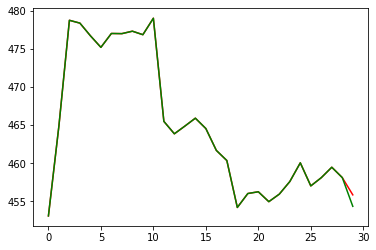

In [252]:
plt.plot(result_pred[70:100], color='r')
plt.plot(result_test[70:100], color='g')
plt.show()

Ouais pour la ligne 10 on voit vraiment bien l'opposition de phase.

On voit dans plot_2 qu'on est parfois en phase parfois à l'opposé mais plutôt pas mal niveau amplitude, selon un certain axe.

faire un algo qui prend l'image et on lui apprend à écrire du rouge parfaitement (ie sur le vert). Il faut que l'ia traduise la photo en des données quantitatives pour qu'on puisse s'en servir à la fin. <- magie noire. rajouter une échelle plus nette 

In [ ]:
loss=tf.keras.losses.MeanSquaredError()
loss(result_pred, result_test).numpy()

41.30302429199219

On voit dans premier_plot que le modèle prédit le mouvement mais moins bien l'amplitude. Une sorte de biais?

Pour moi un indicateur de performance stylé est le suivant : à quelle fréquence le modèle prédit une hausse à juste titre?

In [286]:
def ma_loss(y_pred,y_test):
    score=0
    scores=[]
    for i in range(0, y_pred.shape[0]):#parcours de toutes nos séquences testées.
        move_pred=''#le move qu'on prédit
        if y_pred[99][i]-y_pred[98][i]>0:
            move_pred='UP'
        else:
            move_pred='DOWN'

        move_truth=''#ce qu'il s'est vraiment passé
        if y_test[99][i]-y_test[98][i]>0:
            move_truth='UP'
        else:
            move_truth='DOWN'

        if move_truth==move_pred:
            print('yoyoyoyoyo ',i)
            score+=1
            scores.append((score)/(i+1))
        else:
            print("zob ",i)
            scores.append((score)/(i+1))
        
    return scores      

va permettre de voir si on perd en qualité au fur et à mesure qu'on s'éloigne de l'ordre des données qui ont réalisé l'entrainement.

zob  0
zob  1
yoyoyoyoyo  2
zob  3
zob  4
zob  5
yoyoyoyoyo  6
yoyoyoyoyo  7
zob  8
yoyoyoyoyo  9
yoyoyoyoyo  10
yoyoyoyoyo  11
yoyoyoyoyo  12
zob  13
zob  14
yoyoyoyoyo  15
zob  16
yoyoyoyoyo  17
yoyoyoyoyo  18
yoyoyoyoyo  19
zob  20
zob  21
yoyoyoyoyo  22
zob  23
yoyoyoyoyo  24
yoyoyoyoyo  25
zob  26
yoyoyoyoyo  27
zob  28
zob  29
zob  30
yoyoyoyoyo  31
yoyoyoyoyo  32
zob  33
zob  34
yoyoyoyoyo  35
zob  36
yoyoyoyoyo  37
zob  38
zob  39
yoyoyoyoyo  40
yoyoyoyoyo  41
zob  42
yoyoyoyoyo  43
yoyoyoyoyo  44
zob  45
zob  46
zob  47
yoyoyoyoyo  48
yoyoyoyoyo  49
yoyoyoyoyo  50
zob  51
yoyoyoyoyo  52
yoyoyoyoyo  53
yoyoyoyoyo  54
zob  55
zob  56
yoyoyoyoyo  57
zob  58
zob  59
yoyoyoyoyo  60
zob  61
zob  62
yoyoyoyoyo  63
zob  64
yoyoyoyoyo  65
zob  66
zob  67
yoyoyoyoyo  68
yoyoyoyoyo  69
yoyoyoyoyo  70
yoyoyoyoyo  71
yoyoyoyoyo  72
zob  73
yoyoyoyoyo  74
zob  75
yoyoyoyoyo  76
zob  77
yoyoyoyoyo  78
yoyoyoyoyo  79
yoyoyoyoyo  80
zob  81
zob  82
yoyoyoyoyo  83
zob  84
zob  85
yoyoyoyoyo  86

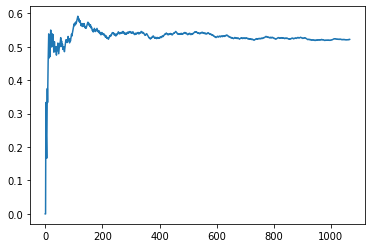

In [295]:
truc=ma_loss(test,predictions)
plt.plot(truc)

ça commence à décroitre autour de 120 jours. ->ré entrainer?

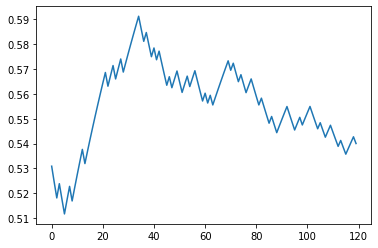

In [296]:
plt.plot(truc[80:200])

s'adapter de sorte à bet que lorsque l'algo est à peak performance?

In [293]:
print(max(truc))

0.591304347826087


next : petit coup de propre. puis, associer avec alpaca et lets go live!!!

important : à dissocier du moment ou je fais de la thune !

moment ou je fais de la thune : reward+=prix_vente(à t=i) > prix_achat(à t<i)

On peut faire une simulation basée sur un capital de départ.

random thoughts :

- à ce stade tout ce qu'on a c'est un algo qui prédit le mouvement du marché jusqu'à 9% mieux que le hasard.

- il faudrait qu'on essaye d'avoir un truc qui se déclenche quand une action est prise. Parce qu'il n'y a que la qu'on perd ou gagne vraiment.